Restarted gwpa (Python 3.9.13)

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.insert(0, 'src')
import config

In [2]:
res_var = [
    'Resistivity_lyrs_9_rad_2_miles'
]

In [3]:
# Constants
rad_well = 2
gama_old_new = 2 # 1: earlier version, 2: latest version of GAMA
all_dom_flag = 1 # 1: All, 2: Domestic
if all_dom_flag == 2:
    well_type_select = {1: 'Domestic', 2: 'DOMESTIC'}.get(gama_old_new) 
else:
    well_type_select = 'All'

# Read dataset
def load_data(version):
    """Load data based on version"""
    filename = "Dataset_processed_GAMAlatest.csv" if version == 2 else "Dataset_processed.csv"
    df = pd.read_csv(config.data_processed / filename)
    return df

def filter_data(df, well_type,all_dom_flag):
    """Filter"""
    exclude_subregions = [14, 15, 10, 19, 18, 9, 6]
    if all_dom_flag == 2:
        df = df[df.well_type ==  well_type] 
    df = df[(df[f'thickness_abovCond_{round(.1*100)}_lyrs_9_rad_2miles'] <= 31) | (~df['SubRegion'].isin(exclude_subregions))]
    return df

# Load and process data
df_main = load_data(gama_old_new)
df = df_main[df_main.well_data_source == 'GAMA'].copy()

df['well_type_encoded'] = pd.factorize(df['well_type'])[0]
df['well_type_encoded'] = df['well_type_encoded'].where(df['well_type'].notna(), df['well_type'])

# separate wells inside cv
well_cv = pd.read_csv(config.data_processed / 'wells_inside_CV_GAMAlatest.csv',index_col=False)
# Assuming df is your dataframe with all wells
df_cv = df[df['well_id'].isin(well_cv['well_id'])]

df = df_cv.copy() #filter_data(df_cv, well_type_select,all_dom_flag)

<ipython-input-3-7f74a37cf615>:16: DtypeWarning: Columns (0,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(config.data_processed / filename)
<ipython-input-3-7f74a37cf615>:35: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  well_cv = pd.read_csv(config.data_processed / 'wells_inside_CV_GAMAlatest.csv',index_col=False)


In [4]:
# Start with the columns you explicitly defined
columns_to_keep = ['well_id','SubRegion','APPROXIMATE LATITUDE', 'APPROXIMATE LONGITUDE']

# # Now add columns for every 3-year period from 1990 to 2022
for year in range(1990, 2022, 3):
    key = f"{year}-{year + 2}" # Adjusted the end year to make it a 5-year period without overlap
    columns_to_keep.append(f'mean_concentration_{key}')

# Now add columns for every 5-year period from 1990 to 2022
# for year in range(1990, 2022, 5):
#     key = f"{year}-{year + 4}" # Adjusted the end year to make it a 5-year period without overlap
#     columns_to_keep.append(f'mean_concentration_{key}')

# Filter the DataFrame
df2 = df[columns_to_keep]

df2 = df2.dropna()

In [5]:
df2.to_csv(config.data_processed / 'nitrate_selectPeriodsmean_gamalatest.csv')

In [6]:
#==========================================
# Codes to create spatial plot
#==========================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
from matplotlib.animation import FuncAnimation
from PIL import Image
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import io
import rasterio
from matplotlib.animation import PillowWriter

/Users/szalam/gwpa/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-6-c9d432de4d29>:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (cal

In [7]:
# Creating the 1km by 1km grid

# Load shapefile
cv = gpd.read_file(config.shapefile_dir / 'cv.shp')

# Define grid size
grid_size = 0.10 # 0.01 approx equal to 1km

# Define the boundaries for your grid
x_min,y_min,x_max,y_max = cv.total_bounds

# Create the grid
x_grid = np.arange(x_min,x_max,grid_size)
y_grid = np.arange(y_min,y_max,grid_size)
grid = []

for x in x_grid:
    for y in y_grid:
        grid.append(gpd.GeoDataFrame({'geometry': gpd.GeoSeries(box(x, y, x+grid_size, y+grid_size))}))

# Concatenate all dataframes to a single one
grid = pd.concat(grid, ignore_index=True)

In [8]:
# Spatially averaging wells inside each grid
df2 = df2.rename(columns={'APPROXIMATE LATITUDE': 'latitude', 'APPROXIMATE LONGITUDE': 'longitude'})
# Convert df to a GeoDataFrame
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))

# Ensure the GeoDataFrames have the same CRS (Coordinate Reference System)
gdf.crs = grid.crs

# Perform a spatial join
joined = gpd.sjoin(gdf, grid, how="inner", op='within')

# For each time period, calculate the mean concentration for each grid cell
mean_concentration_columns = [column for column in df2.columns if "mean_concentration" in column]

for column in mean_concentration_columns:
    # Create a GeoDataFrame with only the wells that have data for this time period
    gdf_time_period = gdf[gdf[column].notna()].copy()

    # Perform a spatial join
    joined = gpd.sjoin(gdf_time_period, grid, how="inner", op='within')

    # Calculate the mean concentration for each grid cell
    mean_concentrations = joined.groupby('index_right')[column].mean()

    # Add this data as a new column to the grid GeoDataFrame
    grid[column] = mean_concentrations

# Reset the index of the grid DataFrame
grid.reset_index(drop=True, inplace=True)

/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please

<Axes: >

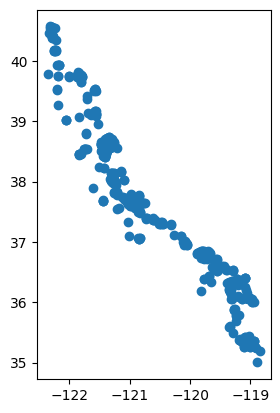

In [9]:
gdf.plot()

In [10]:
# Constants
rad_well = 2
gama_old_new = 2 # 1: earlier version, 2: latest version of GAMA
all_dom_flag = 1 # 1: All, 2: Domestic
if all_dom_flag == 2:
    well_type_select = {1: 'Domestic', 2: 'DOMESTIC'}.get(gama_old_new) 
else:
    well_type_select = 'All'

# Read dataset
def load_data(version):
    """Load data based on version"""
    filename = "Dataset_processed_GAMAlatest.csv" if version == 2 else "Dataset_processed.csv"
    df = pd.read_csv(config.data_processed / filename)
    return df

def filter_data(df, well_type,all_dom_flag):
    """Filter"""
    exclude_subregions = [14, 15, 10, 19, 18, 9, 6]
    if all_dom_flag == 2:
        df = df[df.well_type ==  well_type] 
    df = df[(df[f'thickness_abovCond_{round(.1*100)}_lyrs_9_rad_2miles'] <= 31) | (~df['SubRegion'].isin(exclude_subregions))]
    return df

# Load and process data
df_main = load_data(gama_old_new)
df = df_main[df_main.well_data_source == 'GAMA'].copy()

df['well_type_encoded'] = pd.factorize(df['well_type'])[0]
df['well_type_encoded'] = df['well_type_encoded'].where(df['well_type'].notna(), df['well_type'])

# separate wells inside cv
# well_cv = pd.read_csv(config.data_processed / 'wells_inside_CV_GAMAlatest.csv',index_col=False)
# # Assuming df is your dataframe with all wells
# df_cv = df[df['well_id'].isin(well_cv['well_id'])]

# df = df_cv.copy() #filter_data(df_cv, well_type_select,all_dom_flag)

<ipython-input-10-7b8a961fab2f>:16: DtypeWarning: Columns (0,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(config.data_processed / filename)


In [11]:
# Start with the columns you explicitly defined
columns_to_keep = ['well_id','SubRegion','APPROXIMATE LATITUDE', 'APPROXIMATE LONGITUDE']

# # Now add columns for every 3-year period from 1990 to 2022
for year in range(1990, 2022, 3):
    key = f"{year}-{year + 2}" # Adjusted the end year to make it a 5-year period without overlap
    columns_to_keep.append(f'mean_concentration_{key}')

# Now add columns for every 5-year period from 1990 to 2022
# for year in range(1990, 2022, 5):
#     key = f"{year}-{year + 4}" # Adjusted the end year to make it a 5-year period without overlap
#     columns_to_keep.append(f'mean_concentration_{key}')

# Filter the DataFrame
df2 = df[columns_to_keep]

df2 = df2.dropna()

In [12]:
df2.to_csv(config.data_processed / 'nitrate_selectPeriodsmean_gamalatest.csv')

In [13]:
#==========================================
# Codes to create spatial plot
#==========================================
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
from matplotlib.animation import FuncAnimation
from PIL import Image
from shapely.geometry import box
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import io
import rasterio
from matplotlib.animation import PillowWriter

In [14]:
# Creating the 1km by 1km grid

# Load shapefile
cv = gpd.read_file(config.shapefile_dir / 'cv.shp')

# Define grid size
grid_size = 0.10 # 0.01 approx equal to 1km

# Define the boundaries for your grid
x_min,y_min,x_max,y_max = cv.total_bounds

# Create the grid
x_grid = np.arange(x_min,x_max,grid_size)
y_grid = np.arange(y_min,y_max,grid_size)
grid = []

for x in x_grid:
    for y in y_grid:
        grid.append(gpd.GeoDataFrame({'geometry': gpd.GeoSeries(box(x, y, x+grid_size, y+grid_size))}))

# Concatenate all dataframes to a single one
grid = pd.concat(grid, ignore_index=True)

In [15]:
# Spatially averaging wells inside each grid
df2 = df2.rename(columns={'APPROXIMATE LATITUDE': 'latitude', 'APPROXIMATE LONGITUDE': 'longitude'})
# Convert df to a GeoDataFrame
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))

# Ensure the GeoDataFrames have the same CRS (Coordinate Reference System)
gdf.crs = grid.crs

# Perform a spatial join
joined = gpd.sjoin(gdf, grid, how="inner", op='within')

# For each time period, calculate the mean concentration for each grid cell
mean_concentration_columns = [column for column in df2.columns if "mean_concentration" in column]

for column in mean_concentration_columns:
    # Create a GeoDataFrame with only the wells that have data for this time period
    gdf_time_period = gdf[gdf[column].notna()].copy()

    # Perform a spatial join
    joined = gpd.sjoin(gdf_time_period, grid, how="inner", op='within')

    # Calculate the mean concentration for each grid cell
    mean_concentrations = joined.groupby('index_right')[column].mean()

    # Add this data as a new column to the grid GeoDataFrame
    grid[column] = mean_concentrations

# Reset the index of the grid DataFrame
grid.reset_index(drop=True, inplace=True)

/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/szalam/gwpa/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please

<Axes: >

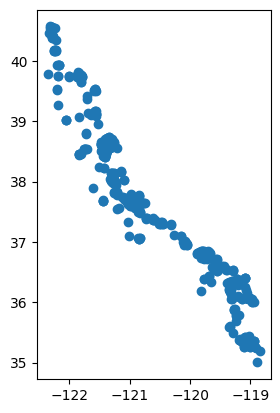

In [16]:
gdf.plot()